# SPINN Visualization

In [ ]:
from setproctitle import setproctitle
setproctitle("SPINN (viz)")

In [ ]:
import os

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
#| default_exp spinn_jax_viz

In [ ]:
#| export
import numpy as np 
import pyvista as pv
import jax 
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import pickle

from cmspinn.spinn_jax import SPINN3d
from cmspinn.mag_viz import create_coordinates

In [ ]:
#| export
class spinn_cube:
    def __init__(self, param_path, parameters_path):
        self.param_path = param_path
        self.parameters_path = parameters_path
    
    def calculate_magnetic_fields(self):
        param_path = self.param_path
        parameters_path = self.parameters_path

        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)

        feat_sizes = parameters['feat_sizes']
        r = parameters['r']
        out_dim = parameters['out_dim']
        Nx = parameters['Nx']
        Ny = parameters['Ny']
        Nz = parameters['Nz']
        b_norm = parameters['b_norm']
        pos_enc = parameters['pos_enc']
        mlp = parameters['mlp']
        n_max_x = parameters['n_max_x']
        n_max_y = parameters['n_max_y']
        n_max_z = parameters['n_max_z']

        subkey = jax.random.PRNGKey(0)
        model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
        model.init(
                    subkey,
                    jnp.ones((Nx, 1)),
                    jnp.ones((Ny, 1)),
                    jnp.ones((Nz, 1))
                   )
        apply_fn = jax.jit(model.apply)

        with open(param_path, 'rb') as f:
            params = pickle.load(f)

        x = jnp.linspace(0, n_max_x, Nx).reshape(-1, 1)
        y = jnp.linspace(0, n_max_y, Ny).reshape(-1, 1)
        z = jnp.linspace(0, n_max_z, Nz).reshape(-1, 1)
        x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

        Bx, By, Bz = apply_fn(params, x, y, z)
        B = jnp.stack([Bx, By, Bz], axis=-1)*b_norm
        
        Bx = B[..., 0]
        By = B[..., 1]
        Bz = B[..., 2]

        co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        co_coords = create_coordinates(co_bounds).reshape(-1, 3)
        co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
        x = co_coord[..., 0]
        y = co_coord[..., 1]
        z = co_coord[..., 2]
        mesh = pv.StructuredGrid(x, y, z)
        vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
        mesh['B'] = vectors
        mesh.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        mesh['mag'] = magnitude
        mesh.active_scalars_name = 'mag'

        self.grid = mesh 
        return self.grid

In [ ]:
parameters_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/SPINN/20170904_000000/parameters.pickle'
params_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/SPINN/20170904_000000/params_10000.pickle'

In [ ]:
spinn = spinn_cube(params_path, parameters_path)

In [ ]:
spinn.calculate_magnetic_fields()

StructuredGrid (0x7f09343062c0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
spinn.grid

StructuredGrid (0x7f09343062c0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
vtk_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/SPINN/20170904_000000/vtk' 
os.makedirs(vtk_path, exist_ok=True)

In [ ]:
B_spinn_vtk_path = os.path.join(vtk_path, 'B_spinn_10000.vtk')
spinn.grid.save(B_spinn_vtk_path)

In [ ]:
B_spinn_mesh = pv.read(B_spinn_vtk_path)

In [ ]:
from cmspinn.mag_viz import mag_plotter

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
B_spinn = mag_plotter(B_spinn_mesh)

In [ ]:
vmin = -3000
vmax = 3000

i_siz = 160
j_siz = 100

i_res = 15
j_res = 15

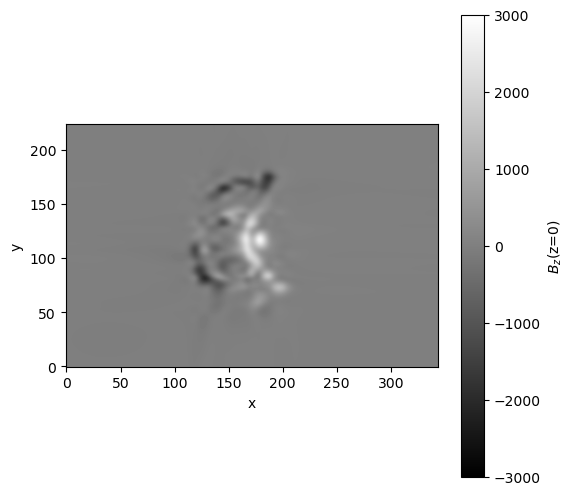

In [ ]:
B_spinn.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

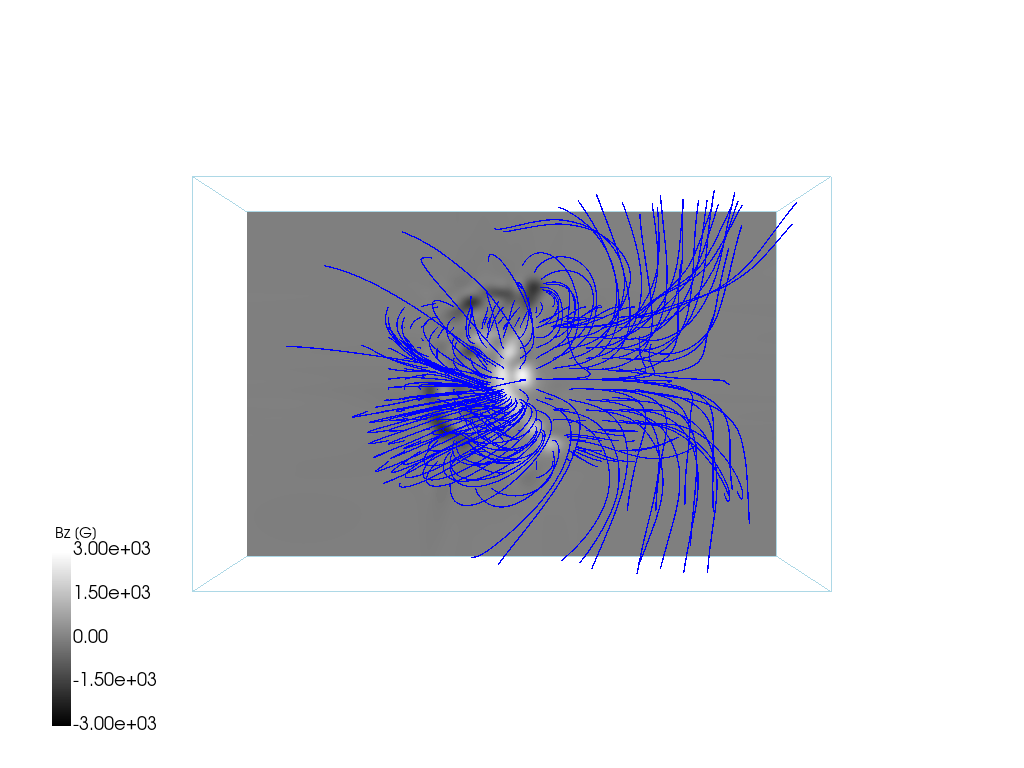

<pyvista.plotting.plotter.Plotter>

In [ ]:
B_spinn.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax)